***Dataset Description***
The file netscience.gml contains a coauthorship network of scientists working on network theory and experiment. The network was compiled from bibliographies of review articles on networks with additional references added by hand. This version contains all components of the network (1589 scientists), not just the largest component of 379 scientists previously published. The network is weighted, with weights assigned as described in M. E. J. Newman, Phys. Rev. E 64, 016132 (2001).

We'll use the Resource Allocation Index as our similarity metric, which has been shown to perform well on scientific collaboration networks. We'll implement k-fold cross-validation to evaluate the performance of our link prediction method.



In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import random
from collections import defaultdict

In [2]:
# Load the network
G = nx.read_gml('netscience.gml')

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Graph density: {nx.density(G):.6f}")
print(f"Is connected: {nx.is_connected(G)}")

# Check for multiple components
components = list(nx.connected_components(G))
print(f"Number of connected components: {len(components)}")
print(f"Size of largest component: {len(max(components, key=len))}")

# Basic network statistics
degrees = [d for n, d in G.degree()]
print(f"Average degree: {np.mean(degrees):.2f}")
print(f"Maximum degree: {max(degrees)}")

Number of nodes: 1589
Number of edges: 2742
Graph density: 0.002173
Is connected: False
Number of connected components: 396
Size of largest component: 379
Average degree: 3.45
Maximum degree: 34


In [3]:
def resource_allocation_index(G, u, v):
    """
    Compute Resource Allocation Index between nodes u and v
    """
    common_neighbors = set(G.neighbors(u)) & set(G.neighbors(v))
    score = 0.0
    for z in common_neighbors:
        score += 1.0 / G.degree(z)
    return score

In [4]:
def k_fold_link_prediction(G, k=5, similarity_func=resource_allocation_index):
    """
    Perform k-fold cross-validation for link prediction
    
    Parameters:
    G: networkx graph
    k: number of folds
    similarity_func: function to compute similarity scores
    
    Returns:
    all_probs: list of similarity scores
    all_labels: list of labels (1 for true edges, 0 for non-edges)
    """
    # Convert to list for indexing
    nodes = list(G.nodes())
    edges = list(G.edges())
    
    # Create non-existent edges for negative examples
    non_edges = list(nx.non_edges(G))
    
    # Shuffle edges and non-edges
    random.shuffle(edges)
    random.shuffle(non_edges)
    
    # Split into k folds
    edge_folds = np.array_split(edges, k)
    non_edge_folds = np.array_split(non_edges, k)
    
    all_probs = []
    all_labels = []
    
    for fold in range(k):
        #rint(f"Processing fold {fold + 1}/{k}")
        
        # Create training graph (remove edges from this fold)
        train_G = G.copy()
        edges_to_remove = edge_folds[fold]
        train_G.remove_edges_from(edges_to_remove)
        
        # Test pairs: removed edges (positive) + some non-edges (negative)
        test_positive = list(edges_to_remove)  # Convert to list
        test_negative = list(non_edge_folds[fold][:len(test_positive)])  # Convert to list
        
        test_pairs = test_positive + test_negative  # Now this works with lists
        test_labels = [1] * len(test_positive) + [0] * len(test_negative)
        
        # Compute similarity scores
        fold_scores = []
        for u, v in test_pairs:
            fold_scores.append(similarity_func(train_G, u, v))
        
        all_probs.extend(fold_scores)
        all_labels.extend(test_labels)
    
    return all_probs, all_labels

def evaluate_link_prediction(probs, labels):
    """
    Evaluate link prediction performance using AUC
    """
    fpr, tpr, thresholds = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc

In [5]:
# Since the full network is large, we'll work with the largest connected component
# to ensure reasonable computation time
probs, labels = k_fold_link_prediction(G, k=5)

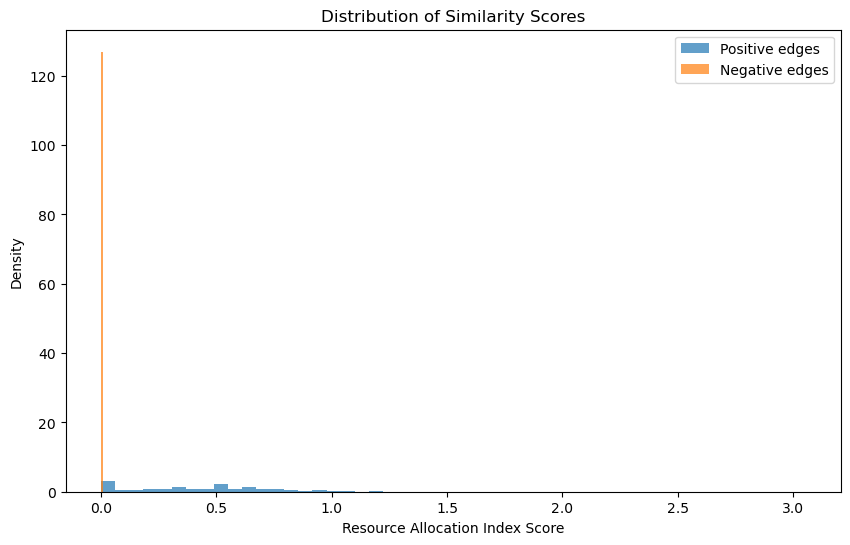

Average score for positive edges: 0.425027
Average score for negative edges: 0.000474
Standard deviation for positive edges: 0.308189
Standard deviation for negative edges: 0.011275


In [6]:
# Analyze the distribution of scores for positive vs negative examples
positive_scores = [probs[i] for i in range(len(probs)) if labels[i] == 1]
negative_scores = [probs[i] for i in range(len(probs)) if labels[i] == 0]

plt.figure(figsize=(10, 6))
plt.hist(positive_scores, bins=50, alpha=0.7, label='Positive edges', density=True)
plt.hist(negative_scores, bins=50, alpha=0.7, label='Negative edges', density=True)
plt.xlabel('Resource Allocation Index Score')
plt.ylabel('Density')
plt.title('Distribution of Similarity Scores')
plt.legend()
plt.show()

print(f"Average score for positive edges: {np.mean(positive_scores):.6f}") #this value reprsents the average similarity score for edges that actually exist in the network
print(f"Average score for negative edges: {np.mean(negative_scores):.6f}") #this value represents the average similarity score for edges that do not exist in the network
print(f"Standard deviation for positive edges: {np.std(positive_scores):.6f}")
print(f"Standard deviation for negative edges: {np.std(negative_scores):.6f}")

In [7]:
import numpy as np
import networkx as nx

# --- Common Neighbors ---
def common_neighbors_index(G, u, v):
    return len(set(G.neighbors(u)) & set(G.neighbors(v)))

# --- Salton Index ---
def salton_index(G, u, v):
    cn = len(set(G.neighbors(u)) & set(G.neighbors(v)))
    denom = np.sqrt(G.degree(u) * G.degree(v))
    return cn / denom if denom != 0 else 0

# --- Jaccard Coefficient ---
def jaccard_index(G, u, v):
    nu, nv = set(G.neighbors(u)), set(G.neighbors(v))
    inter = len(nu & nv)
    union = len(nu | nv)
    return inter / union if union != 0 else 0

# --- Sørensen Index ---
def sorensen_index(G, u, v):
    nu, nv = set(G.neighbors(u)), set(G.neighbors(v))
    inter = len(nu & nv)
    denom = len(nu) + len(nv)
    return 2 * inter / denom if denom != 0 else 0

# --- Hub Promoted Index (HPI) ---
def hub_promoted_index(G, u, v):
    inter = len(set(G.neighbors(u)) & set(G.neighbors(v)))
    denom = min(G.degree(u), G.degree(v))
    return inter / denom if denom != 0 else 0

# --- Hub Depressed Index (HDI) ---
def hub_depressed_index(G, u, v):
    inter = len(set(G.neighbors(u)) & set(G.neighbors(v)))
    denom = max(G.degree(u), G.degree(v))
    return inter / denom if denom != 0 else 0

# --- Leicht-Holme-Newman Index (LHN) ---
def leicht_holme_newman_index(G, u, v):
    inter = len(set(G.neighbors(u)) & set(G.neighbors(v)))
    denom = G.degree(u) * G.degree(v)
    return inter / denom if denom != 0 else 0

# --- Preferential Attachment ---
def preferential_attachment(G, u, v):
    return G.degree(u) * G.degree(v)

# --- Adamic-Adar Index ---
def adamic_adar_index(G, u, v):
    common_neighbors = set(G.neighbors(u)) & set(G.neighbors(v))
    score = 0.0
    for z in common_neighbors:
        if G.degree(z) > 1:
            score += 1.0 / np.log(G.degree(z))
    return score

# --- Resource Allocation Index ---
def resource_allocation_index(G, u, v):
    common_neighbors = set(G.neighbors(u)) & set(G.neighbors(v))
    score = sum(1.0 / G.degree(z) for z in common_neighbors if G.degree(z) > 0)
    return score

# --- Local Path Index ---
def local_path_index(G, u, v, alpha=0.01):
    # A^3 is approximated by counting length-3 paths
    A = nx.to_numpy_array(G)
    A3 = np.linalg.matrix_power(A, 3)
    A2 = np.linalg.matrix_power(A, 2)
    cn = A2[G.nodes().index(u), G.nodes().index(v)]
    return cn + alpha * A3[G.nodes().index(u), G.nodes().index(v)]

# --- Self created similarity score --- 
def component_hub_promoted_index(G, u, v):
    score = hub_promoted_index(G, u, v)
    Cu = int(len(nx.node_connected_component(G, u)))
    Cv = int(len(nx.node_connected_component(G, v)))
    return score*np.log(Cu*Cv)

def component_salton_index(G, u, v):
    score = salton_index(G, u, v)
    Cu = int(len(nx.node_connected_component(G, u)))
    Cv = int(len(nx.node_connected_component(G, v)))
    return score*np.log(Cu*Cv)


In [8]:
Local_similarity_functions = {
    "CN": common_neighbors_index,
    "Salton": salton_index,
    "Jaccard": jaccard_index,
    "Sorensen": sorensen_index,
    "HPI": hub_promoted_index,
    "HDI": hub_depressed_index,
    "LHN": leicht_holme_newman_index,
    "PA": preferential_attachment,
    "AA": adamic_adar_index,
    "RA": resource_allocation_index,
    "Component HPI": component_hub_promoted_index,
    "Component Salton": component_salton_index
}

results = {}

for name, func in Local_similarity_functions.items():
    print(f"Starting k-fold cross-validation for {name}...")
    probs, labels = k_fold_link_prediction(G, k=15, similarity_func=func)
    fpr, tpr, roc_auc = evaluate_link_prediction(probs, labels)
    results[name] = roc_auc
    print(f"{name} AUC: {roc_auc:.4f}")

print("\nFinal AUC scores:")
for name, auc_val in results.items():
    print(f"{name}: {auc_val:.4f}")


Starting k-fold cross-validation for CN...
CN AUC: 0.9436
Starting k-fold cross-validation for Salton...
Salton AUC: 0.9431
Starting k-fold cross-validation for Jaccard...
Jaccard AUC: 0.9462
Starting k-fold cross-validation for Sorensen...
Sorensen AUC: 0.9489
Starting k-fold cross-validation for HPI...
HPI AUC: 0.9489
Starting k-fold cross-validation for HDI...
HDI AUC: 0.9441
Starting k-fold cross-validation for LHN...
LHN AUC: 0.9465
Starting k-fold cross-validation for PA...
PA AUC: 0.6758
Starting k-fold cross-validation for AA...
AA AUC: 0.9466
Starting k-fold cross-validation for RA...
RA AUC: 0.9484
Starting k-fold cross-validation for Component HPI...
Component HPI AUC: 0.9459
Starting k-fold cross-validation for Component Salton...
Component Salton AUC: 0.9424

Final AUC scores:
CN: 0.9436
Salton: 0.9431
Jaccard: 0.9462
Sorensen: 0.9489
HPI: 0.9489
HDI: 0.9441
LHN: 0.9465
PA: 0.6758
AA: 0.9466
RA: 0.9484
Component HPI: 0.9459
Component Salton: 0.9424


In [9]:
import numpy as np
import networkx as nx

#GLOBAL METRICS

# --- Katz Index ---
def katz_index(G, u, v, beta=0.005, max_iter=5):
    A = nx.to_numpy_array(G)
    n = A.shape[0]
    I = np.eye(n)
    M = np.linalg.inv(I - beta * A) - I
    nodes = list(G.nodes())
    i, j = nodes.index(u), nodes.index(v)
    return M[i, j]

# --- Random Walk with Restart (RWR) ---
def rwr_index(G, u, v, c=0.85, tol=1e-6):
    nodes = list(G.nodes())
    n = len(nodes)
    idx = {node: i for i, node in enumerate(nodes)}
    A = nx.to_numpy_array(G)
    degs = A.sum(axis=1)
    P = np.divide(A, degs[:, None], out=np.zeros_like(A), where=degs[:, None]!=0)

    r = np.zeros(n)
    r[idx[u]] = 1.0
    prev = np.zeros(n)
    while np.linalg.norm(r - prev) > tol:
        prev = r.copy()
        r = (1 - c) * np.eye(n)[idx[u]] + c * P.T @ r
    return r[idx[v]]

# --- Shortest Path Similarity ---
def shortest_path_similarity(G, u, v):
    try:
        d = nx.shortest_path_length(G, u, v)
        return 1 / (d + 1)  # closer = higher similarity
    except nx.NetworkXNoPath:
        return 0.0

# --- LHNG (Leicht-Holme-Newman Global) ---
def lhng_index(G, u, v, gamma=0.5):
    inter = len(set(G.neighbors(u)) & set(G.neighbors(v)))
    du, dv = G.degree(u), G.degree(v)
    denom = (du * dv) ** gamma
    return inter / denom if denom != 0 else 0

# --- Average Commute Time (ACT) ---
def average_commute_time(G, u, v):
    L = nx.laplacian_matrix(G).toarray()
    L_pinv = np.linalg.pinv(L)
    nodes = list(G.nodes())
    i, j = nodes.index(u), nodes.index(v)
    return L_pinv[i, i] + L_pinv[j, j] - 2 * L_pinv[i, j]

# --- Normalized ACT (NACT) ---
def normalized_act(G, u, v):
    act = average_commute_time(G, u, v)
    du, dv = G.degree(u), G.degree(v)
    return act / (du * dv) if du * dv > 0 else 0

# --- Cos+ Similarity ---
def cos_plus_similarity(G, u, v):
    A = nx.to_numpy_array(G)
    nodes = list(G.nodes())
    i, j = nodes.index(u), nodes.index(v)
    vec_u, vec_v = A[i], A[j]
    num = np.dot(vec_u, vec_v)
    denom = np.linalg.norm(vec_u) * np.linalg.norm(vec_v)
    return num / denom if denom != 0 else 0

# --- Matrix Factorization Similarity (MF) ---
def matrix_factorization_similarity(G, u, v, rank=8):
    A = nx.to_numpy_array(G)
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    U_r = U[:, :rank] * np.sqrt(S[:rank])
    V_r = Vt[:rank, :].T * np.sqrt(S[:rank])
    nodes = list(G.nodes())
    i, j = nodes.index(u), nodes.index(v)
    return np.dot(U_r[i], V_r[j])

# --- Similarity Propagation Model (SPM) / SimRank-like ---
def spm_index(G, u, v, c=0.8, max_iter=5):
    A = nx.to_numpy_array(G)
    n = A.shape[0]
    nodes = list(G.nodes())
    deg = A.sum(axis=1)
    S = np.eye(n)
    for _ in range(max_iter):
        S_new = c * A.T @ (S / np.outer(deg, deg)) @ A
        np.fill_diagonal(S_new, 1)
        S = S_new
    i, j = nodes.index(u), nodes.index(v)
    return S[i, j]


In [10]:
from tqdm import tqdm

best_metric = resource_allocation_index
nonexistent_pairs = list(nx.non_edges(G))

scores = []
for u, v in tqdm(nonexistent_pairs, desc="Scoring non-edges"):
    scores.append((best_metric(G, u, v), (u, v)))

scores.sort(reverse=True, key=lambda x: x[0])

top_predictions = scores[:200]
for score, (u, v) in top_predictions:
    print(f"{u} — {v}: {score:.6f}")

Scoring non-edges: 100%|██████████| 1258924/1258924 [00:03<00:00, 407746.42it/s]


WHITE, H — ARABIE, P: 0.666667
JURKIEWICZ, J — CORREIA, J: 0.666667
VAZQUEZ, A — BARRAT, A: 0.638095
GARCIADELAMO, A — PELLO, J: 0.600000
GARCIADELAMO, A — FLORES, J: 0.600000
HONG, H — JEONG, H: 0.588095
PENNOCK, D — COETZEE, F: 0.566667
COETZEE, F — GLOVER, E: 0.566667
GOLTSEV, A — SAMUKHIN, A: 0.533333
DECASTRO, R — ION, P: 0.500000
BOHLAND, J — LEVY, W: 0.500000
SALWINSKI, L — YEATES, T: 0.500000
GANI, J — KENDALL, D: 0.500000
ZHU, J — HUANG, Z: 0.500000
BHAN, A — CHUNG, F: 0.500000
BHAN, A — LU, L: 0.500000
PANDIT, S — JALAN, S: 0.500000
MIELSCH, L — DAVIDSEN, J: 0.500000
RICE, D — YEATES, T: 0.500000
MCGRAW, P — MACGRAW, P: 0.500000
MOKHTARZADA, Z — KANG, D: 0.500000
SOMPOLINSKY, H — GOLOMB, D: 0.500000
TRAVERS, J — KORTE, C: 0.500000
RINZEL, J — HANSEL, D: 0.500000
CSETE, M — CARLSON, J: 0.500000
RODRIGUEZESTEBAN, R — KANG, D: 0.500000
COULUMB, S — BERNARD, D: 0.500000
MCINTOSH, A — SPORNS, O: 0.500000
RUSSELL, D — SPORNS, O: 0.500000
BARON, M — YEATES, T: 0.500000
LEVITT, R — C

In [11]:
# Rank non-edges by score, tie-breaking on total degree (authors with more publications first)
best_metric = resource_allocation_index
nonexistent_pairs = list(nx.non_edges(G))

scores = []
for u, v in tqdm(nonexistent_pairs, desc="Scoring non-edges"):
    score = best_metric(G, u, v)
    total_deg = G.degree(u) + G.degree(v)
    scores.append((score, total_deg, (u, v)))

scores.sort(key=lambda x: (x[0], x[1]), reverse=True)

top_predictions = scores[:200]
for score, total_deg, (u, v) in top_predictions:
    print(f"{u} — {v}: score={score:.6f}, total_degree={total_deg}")

Scoring non-edges: 100%|██████████| 1258924/1258924 [00:04<00:00, 252737.83it/s]


WHITE, H — ARABIE, P: score=0.666667, total_degree=14
JURKIEWICZ, J — CORREIA, J: score=0.666667, total_degree=4
VAZQUEZ, A — BARRAT, A: score=0.638095, total_degree=16
GARCIADELAMO, A — PELLO, J: score=0.600000, total_degree=7
GARCIADELAMO, A — FLORES, J: score=0.600000, total_degree=7
HONG, H — JEONG, H: score=0.588095, total_degree=33
PENNOCK, D — COETZEE, F: score=0.566667, total_degree=7
COETZEE, F — GLOVER, E: score=0.566667, total_degree=7
GOLTSEV, A — SAMUKHIN, A: score=0.533333, total_degree=4
RUSSELL, D — SPORNS, O: score=0.500000, total_degree=18
MCINTOSH, A — SPORNS, O: score=0.500000, total_degree=10
SALWINSKI, L — YEATES, T: score=0.500000, total_degree=8
RICE, D — YEATES, T: score=0.500000, total_degree=8
BARON, M — YEATES, T: score=0.500000, total_degree=8
BHAN, A — CHUNG, F: score=0.500000, total_degree=7
BHAN, A — LU, L: score=0.500000, total_degree=7
MOKHTARZADA, Z — KANG, D: score=0.500000, total_degree=5
SOMPOLINSKY, H — GOLOMB, D: score=0.500000, total_degree=5
RO

In [12]:
# Show collaborators for nodes appearing in the top 10 predicted links
top_pairs = [entry[2] for entry in scores[:10]]  # (score, total_deg, (u, v))
unique_authors = sorted({author for pair in top_pairs for author in pair})

for author in unique_authors:
    collaborators = sorted(G.neighbors(author))
    print(f"{author}")
    print("  Collaborators:", ", ".join(collaborators))
    print()

ARABIE, P
  Collaborators: BOORMAN, S, BREIGER, R

BARRAT, A
  Collaborators: BARTHELEMY, M, PASTORSATORRAS, R, VESPIGNANI, A, WEIGT, M

COETZEE, F
  Collaborators: FLAKE, G, GILES, C, LAWRENCE, S

CORREIA, J
  Collaborators: BURDA, Z, KRZYWICKI, A

FLORES, J
  Collaborators: CRIADO, R, HERNANDEZBERMEJO, B, PELLO, J, ROMANCE, M

GARCIADELAMO, A
  Collaborators: CRIADO, R, HERNANDEZBERMEJO, B, ROMANCE, M

GLOVER, E
  Collaborators: FLAKE, G, GILES, C, LAWRENCE, S, PENNOCK, D

GOLTSEV, A
  Collaborators: DOROGOVTSEV, S, MENDES, J

HONG, H
  Collaborators: CHOI, M, KAHNG, B, KIM, B, OH, E, PARK, H, RHO, K

JEONG, H
  Collaborators: ALBERT, R, BARABASI, A, BIANCONI, G, DERENYI, I, FARKAS, I, GOH, K, HAN, S, HOLME, P, HUSS, M, KAHNG, B, KIM, B, KIM, D, MASON, S, NEDA, Z, OH, E, OLTVAI, Z, PARK, Y, PODANI, J, RAVASZ, E, RHO, K, SCHUBERT, A, SZATHMARY, E, TOMBOR, B, TU, Y, VICSEK, T, YOOK, S, YOON, C

JURKIEWICZ, J
  Collaborators: BURDA, Z, KRZYWICKI, A

PELLO, J
  Collaborators: CRIADO, R, 

Scoring negatives: 100%|██████████| 1258924/1258924 [00:03<00:00, 329884.97it/s]


Number of positive scores above 0.0294: 1254944 out of 1258924
[       inf 3.97731481 1.77698413 1.55952381 1.53455988 1.36805556
 1.33333333 1.31111111 1.27807018 1.26666667 1.21322751 1.16746032
 1.16666667 1.16560847 1.15324675 1.11666667 1.1127451  1.1
 1.07361111 1.0457672  1.04166667 1.03703704 1.03675856 1.03392857
 1.03333333 1.02564745 1.         0.97940115 0.97619048 0.95873016
 0.94210526 0.93947368 0.93333333 0.91666667 0.9        0.88888889
 0.88773449 0.87777778 0.87698413 0.875      0.86011905 0.85714286
 0.84285714 0.84090909 0.82662338 0.82539683 0.80952381 0.8
 0.79487734 0.79166667 0.77777778 0.77777778 0.77564745 0.77467532
 0.76691729 0.76666667 0.75162338 0.75       0.745671   0.74285714
 0.73941799 0.73517126 0.73333333 0.73333333 0.72698413 0.72619048
 0.7254902  0.725      0.72150072 0.71987734 0.71904762 0.71428571
 0.71111111 0.71031746 0.70535714 0.7020202  0.7012987  0.7
 0.69967532 0.6952381  0.69166667 0.69090909 0.68452381 0.68382353
 0.68333333 0.677777

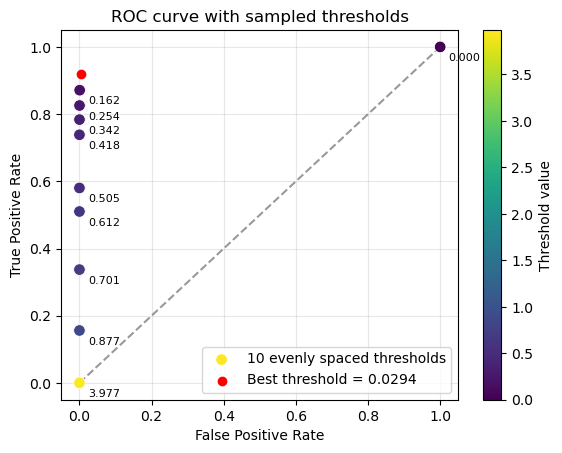

In [19]:
from sklearn.metrics import roc_curve
from tqdm import tqdm

def optimal_threshold_top_left(G, similarity_func, negative_ratio=1.0, random_state=42):
    rng = np.random.default_rng(random_state)

    # Scores for existing links (positives)
    positives = list(G.edges())
    pos_scores = np.array([similarity_func(G, u, v) for u, v in tqdm(positives, desc="Scoring positives")])

    # Scores for sampled non-links (negatives)
    non_edges = np.array(list(nx.non_edges(G)))
    neg_scores = np.array([similarity_func(G, u, v) for u, v in tqdm(non_edges, desc="Scoring negatives")])

    #print how many possitive scores above 0.05 we have
    print(f"Number of positive scores above 0.0294: {(neg_scores < 0.0294).sum()} out of {len(neg_scores)}")


    y_true = np.concatenate([np.ones_like(pos_scores), np.zeros_like(neg_scores)])
    y_scores = np.concatenate([pos_scores, neg_scores])

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    distances = np.sqrt((fpr - 0.0) ** 2 + (tpr - 1.0) ** 2)
    best_idx = np.argmin(distances)

    best = {
        "threshold": float(thresholds[best_idx]),
        "fpr": float(fpr[best_idx]),
        "tpr": float(tpr[best_idx]),
        "distance": float(distances[best_idx]),
    }
    return best, fpr, tpr, thresholds, y_scores, y_true

best, fpr, tpr, thresh, y_scores, y_true = optimal_threshold_top_left(
    G, resource_allocation_index, negative_ratio=1.0, random_state=42
)

print(thresh)
print("Best RA threshold (closest to ROC top-left):")
finite_idx = np.flatnonzero(np.isfinite(thresh))
sample_count = min(10, finite_idx.size)
sample_idx = finite_idx[np.linspace(0, finite_idx.size - 1, sample_count, dtype=int)]
sampled_fpr = fpr[sample_idx]
sampled_tpr = tpr[sample_idx]
sampled_thresh = thresh[sample_idx]

# Chat-gpt ahh plot
threshold_markers = plt.scatter(
    sampled_fpr,
    sampled_tpr,
    c=sampled_thresh,
    cmap="viridis",
    s=70,
    edgecolor="white",
    linewidth=0.6,
    zorder=4,
    label=f"{sample_count} evenly spaced thresholds"
)
for fp, tp, th in zip(sampled_fpr, sampled_tpr, sampled_thresh):
    plt.annotate(f"{th:.3f}", (fp, tp), textcoords="offset points", xytext=(6, -10), fontsize=8)

plt.scatter(best["fpr"], best["tpr"], color="red", label=f"Best threshold = {best['threshold']:.4f}", zorder=5)
plt.plot([0, 1], [0, 1], "k--", alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve with sampled thresholds")
plt.legend()
plt.grid(True, alpha=0.3)
plt.colorbar(threshold_markers, label="Threshold value")
plt.show()

In [14]:
print(pos_scores.min(), pos_scores.max())
print(neg_scores.min(), neg_scores.max())


NameError: name 'pos_scores' is not defined